# 导入数据

In [1]:
import pandas as pd
import numpy as np
import os
from pixelmed_calc.medical_imaging.RadiologyComponents.survival import plot_survival_analysis ,cox_prediction
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.makedirs('results/img', exist_ok=True)
os.makedirs('results/model_weight', exist_ok=True)
os.makedirs('results/pred', exist_ok=True)
inputfile = 'clinic.csv'
labelfile='group_1.csv'
data_feature=pd.read_csv(inputfile)
mean_values = data_feature.loc[:, data_feature.columns != 'ID'].mean()
data_feature.fillna(mean_values, inplace=True)
data_label=pd.read_csv(labelfile)
#注意clinic.csv如果包含label列，把merged_data = pd.merge(data_feature.drop(['label'],axis=1), data_label, on='ID')改为merged_data = pd.merge(data_feature, data_label, on='ID')
merged_data = pd.merge(data_feature.drop(['label'],axis=1), data_label, on='ID')
merged_data.columns = merged_data.columns.str.replace(r'-', '_')
merged_data=merged_data[['ID','duration','Age','Subtype','Tumorsize','TNMstage'	,'VPI','ith_score','hab_rad_sign','label','group']]
merged_data

,ID,duration,Age,Subtype,Tumorsize,TNMstage,VPI,ith_score,hab_rad_sign,label,group
0,2.nii.gz,131.300000,51,2,1,1,0,0.667914,0.118837,0,train
1,3.nii.gz,129.400000,58,2,2,2,0,0.662742,0.005323,0,train
2,4.nii.gz,128.200000,54,3,2,2,0,0.500000,0.016271,0,train
3,5.nii.gz,127.200000,56,2,2,4,1,0.661033,0.004250,0,train
4,6.nii.gz,127.070000,65,3,4,4,1,0.714916,0.196996,0,train
...,...,...,...,...,...,...,...,...,...,...,...
491,493.nii.gz,15.200000,70,2,3,4,1,0.885705,0.837226,1,test
492,494.nii.gz,20.933333,57,2,3,4,1,0.000000,0.340485,1,test
493,495.nii.gz,21.966667,42,1,1,1,0,0.000000,0.004103,0,test
494,496.nii.gz,21.966667,48,2,2,2,0,0.000829,0.332986,0,test


In [4]:
from pixelmed_calc.medical_imaging.RadiologyComponents.components1 import sel_standard_data
#method='robust',standard,minmax
merged_data = sel_standard_data(merged_data, merged_data.columns[2:3],method='robust')
merged_data

,ID,duration,Age,Subtype,Tumorsize,TNMstage,VPI,ith_score,hab_rad_sign,label,group
0,2.nii.gz,131.300000,-0.642857,2,1,1,0,0.667914,0.118837,0,train
1,3.nii.gz,129.400000,-0.142857,2,2,2,0,0.662742,0.005323,0,train
2,4.nii.gz,128.200000,-0.428571,3,2,2,0,0.500000,0.016271,0,train
3,5.nii.gz,127.200000,-0.285714,2,2,4,1,0.661033,0.004250,0,train
4,6.nii.gz,127.070000,0.357143,3,4,4,1,0.714916,0.196996,0,train
...,...,...,...,...,...,...,...,...,...,...,...
491,493.nii.gz,15.200000,0.714286,2,3,4,1,0.885705,0.837226,1,test
492,494.nii.gz,20.933333,-0.214286,2,3,4,1,0.000000,0.340485,1,test
493,495.nii.gz,21.966667,-1.285714,1,1,1,0,0.000000,0.004103,0,test
494,496.nii.gz,21.966667,-0.857143,2,2,2,0,0.000829,0.332986,0,test


In [5]:
data_sel = merged_data

In [7]:

n_classes = 2
x_train=data_sel[data_sel['group']=='train'].drop(['group'],axis=1)
y_train=data_sel[data_sel['group']=='train']['label']

x_test=data_sel[data_sel['group']=='test'].drop(['group'],axis=1)
y_test=data_sel[data_sel['group']=='test']['label']

x_all=data_sel.drop(['group'],axis=1)
y_all=data_sel['label']

column_names = x_all.columns
print(f"训练集样本数：{x_train.shape}, 测试集样本数：{x_test.shape}")

训练集样本数：(302, 10), 测试集样本数：(65, 10)


In [8]:
from lifelines import CoxPHFitter
cox_data_train=x_train.drop('ID', axis=1)
cox_data_test=x_test.drop('ID', axis=1)
cph = CoxPHFitter(penalizer=0.1)
cph.fit(cox_data_train[list(cox_data_train.columns)], duration_col='duration', event_col='label')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 302 total observations, 251 right-censored observations>
             duration col = 'duration'
                event col = 'label'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 302
number of events observed = 51
   partial log-likelihood = -202.04
         time fit was run = 2024-07-31 00:32:43 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Age            0.33       1.39       0.16             0.02             0.64                 1.02                 1.89
Subtype        0.27       1.31       0.14            -0.01             0.56                 0.99                 1.74
Tumorsize     -0.07       0.94       0.15            -0.37             0.23                 0.69                 1.26
TNMstage       0.01       1.01       0.14            -0.27             0.29                 0.76                 1.33
VPI            0.90       2.46       0.29             0.32             1.47                 1.38                 4.37
ith_score      1.48       4.38       0.49             0.51             2.44                 1.66                11.52
hab_rad_sign   3.40      29.85       0.36             2.69             4.11                14.66                60.76

               cmp to     z      p   -log2(p)
covariate                                    
Age              0.00  2.08   0.04       4.72
Subtype          0.00  1.89   0.06       4.11
Tumorsize        0.00 -0.44   0.66       0.60
TNMstage         0.00  0.05   0.96       0.05
VPI              0.00  3.06 <0.005       8.83
ith_score        0.00  2.99 <0.005       8.49
hab_rad_sign     0.00  9.36 <0.005      66.82
---
Concordance = 0.96
Partial AIC = 418.09
log-likelihood ratio test = 169.42 on 7 df
-log2(p) of ll-ratio test = 107.89

In [9]:
import pandas as pd
#保存 cox模型预测结果

coxset = [(x_train,'train'),(x_test,'test')]

for subset,name in coxset:
    resuslts = cox_prediction(cph,  subset[list(cox_data_train.columns)], ID=subset['ID'])
    resuslts.to_csv(f'results/combined_cox_{name}.csv', index=False)


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
model_names = ['Cox']
y_pred = cph.predict_partial_hazard(cox_data_train[list(cox_data_train.columns)])
cox_data_train = pd.concat([cox_data_train, y_pred], axis=1)
cox_data_train['HR'] = cox_data_train[0] > 1

y_pred_test = cph.predict_partial_hazard(cox_data_test[list(cox_data_test.columns)])
cox_data_test = pd.concat([cox_data_test, y_pred_test], axis=1)
cox_data_test['HR'] = cox_data_test[0] > 1


In [14]:
from lifelines.utils import concordance_index
#读取best分类器结果
bt_result_rad=pd.read_csv('AdaBoost_train_proba.csv')
bt_result_hab=pd.read_csv('pred_MLP_train.csv')
bt_result_combine=pd.read_csv('pred_MLP_train.csv')
c_index_list = [[cph.concordance_index_, 
                 concordance_index(cox_data_train['duration'], bt_result_rad['proba'], cox_data_train['label']),
                 concordance_index(cox_data_train['duration'], bt_result_hab['label-0'], cox_data_train['label']),
                 concordance_index(cox_data_train['duration'], bt_result_combine['label-0'], cox_data_train['label']),
                 
                 'Train']]
pd.DataFrame(c_index_list, columns=['Nomogram', 'Rad', 'Hab','combine','Cohort'])

,Nomogram,Rad,Hab,combine,Cohort
0,0.963189,0.520857,0.816799,0.816799,Train


In [15]:
from lifelines.utils import concordance_index
#读取best分类器结果

bt_result_rad=pd.read_csv('pred_MLP_test.csv')
bt_result_hab=pd.read_csv('pred_MLP_test.csv')
bt_result_combine=pd.read_csv('pred_MLP_test.csv')
c_index_list_test = [[concordance_index(cox_data_test['duration'], -cox_data_test[0], cox_data_test['label']),
                 concordance_index(cox_data_test['duration'], bt_result_rad['label-0'], cox_data_test['label']),
                 concordance_index(cox_data_test['duration'], bt_result_hab['label-0'], cox_data_test['label']),
                  concordance_index(cox_data_test['duration'], bt_result_combine['label-0'], cox_data_test['label']),
                 'Test']]
pd.DataFrame(c_index_list_test, columns=['Nomogram-Cox', 'Rad', 'Hab','combine','Cohort'])

,Nomogram-Cox,Rad,Hab,combine,Cohort
0,0.932961,0.519553,0.519553,0.519553,Test


训练集

c-index p-value: 3.6796337494702364e-31


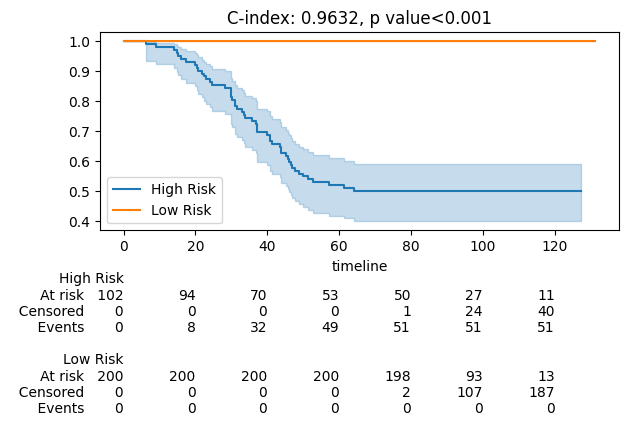

In [16]:
plot_survival_analysis(cox_data_train, c_index_list[0][0],fig_save_path='results/img/km.svg')

测试集

c-index p-value: 0.0005135170644801818


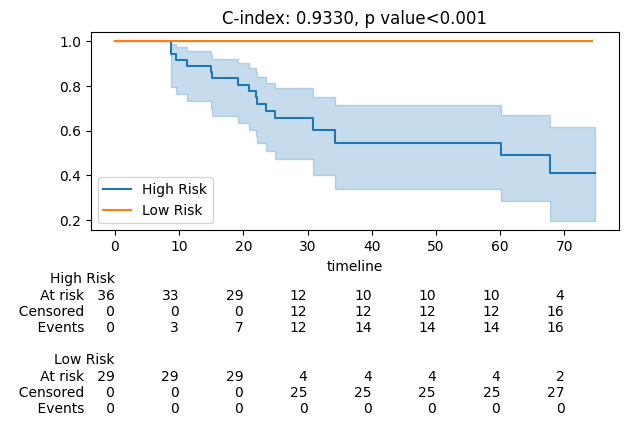

In [17]:
plot_survival_analysis(cox_data_test, c_index_list_test[0][0],fig_save_path='results/img/km_test.svg')